<a href="https://colab.research.google.com/github/Blistt/Image-Retrieval/blob/main/ArtisticSimilarity_G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMAGE RETRIEVAL**

This notebook implements a very simple Content Based Image Retrieval (CBIR) system, that takes one image as a query, and outputs a set of similar images from a given database of images, ranked by their level of similarity to the query image. This system uses the VGG-19 architecture as a feature extractor to create embeddings for the images. Image-to-image similarity is computed on these embeddings.

<div align="center">
  <img src="illustrations/illustration1.png" alt="Art similarity illustration" width="400"><br>
  Figure 1. Which of the 2 images on the right is more similar to the one on the left? While image a) may have the same color palette, image b) has a highly similar composition.
</div>



**Loading Images**

The first step is loading the images. The VGG-19 architecture expects certain characteristics of an input image, such as the image being a tensor with shape (224 height, 224 width, 3 color channels), in a BGR scheme (as opposed to the typical RGB), etc. Fortunarely, with VGG-19 being a staple architecture in computer vision, Keras provides a pre-processing function that performs all the necessary transformations to get your images ready for passing through this network.
We will use this function when loading the images into our dataset.

In [1]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def load_images(path):
  path = Path(path)
  # Ensures only valid image files are loaded
  img_paths = list(path.glob('*.jpg')) + list(path.glob('*.jpeg')) + list(path.glob('*.png')) \
              + list(path.glob('*.gif'))
  images = []
  print(f'Loading {len(img_paths)} images')
  for img_path in tqdm(img_paths):
    # load image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    images.append(img)
  print('images loaded as' , type(images[0]), 'type')
  return images

import matplotlib.pyplot as plt

def show_images(images, filename):
    # Display image in new window
    fig = plt.figure(figsize=(14, 8))

    for i in range(1, len(images)+1):
      ax = fig.add_subplot(len(images)//6, 6, i)
      if i == 1:
        ax.set_title('Query Image')
      else:
        title = 'neighbor' + str(i-1)
        ax.set_title(title)

      plt.imshow(np.squeeze(images[i-1]))
      plt.axis('off')
    plt.show()

We won't be performing any training in this system, as we will be leveraging a pre-trained model and identifying similar images in an unsupervised fashion through nearest neighbor search. Nonetheless, we selected a subset of images to use as queries to exemplify the results the system produces. We will call this subset of queries the *test* dataset and the remainder of the images as the *train* dataset.

For visualization purposes, we will make a copy of the dataset that won't go through VGG-19 pre-processing, so that we are able to look at the images in their original state. This strategy is not memory-efficient, but given the small size of our dataset, it is feasible.

In [2]:
# Load 'test' dataset (query images)
test_path = 'data/test/'
test_images = load_images(test_path)

# Load 'train' dataset (candidate images to be retrieved)
train_path = 'D:/documents/anime/a-photos/'
train_images = load_images(train_path)

Loading 36 images


100%|██████████| 36/36 [00:01<00:00, 22.59it/s]


images loaded as <class 'PIL.Image.Image'> type
Loading 1112 images


100%|██████████| 1112/1112 [01:03<00:00, 17.52it/s]

images loaded as <class 'PIL.Image.Image'> type


**Load model**

In this cell, we initialize the VGG-19 model with its pre-trained weights on the *ImageNet* dataset from TF directly. VGG-19 is a classifier model, which means it outputs a classification vector that tells us the class the image belongs to (e.g., cat, car, plane). 

However, we are not going to use it as a classifier. Instead, we are interested in the internal representation the network generates to arrive to such classifications. To that end, in this cell we also configure the model to output the activation maps of its convolutional layers, or so called *feature maps*, instead of the classification it makes.

In [3]:
from keras import backend as K 

model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",)

model.summary()

layer_outputs = [layer.output for layer in model.layers[1:-1]]  # Identifies layer outputs
# Creates a model that will return the layer feature maps as outputs for a given image
visual_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs) 

layer_names = [layer.name for layer in visual_model.layers]

for i, layer in enumerate(layer_names):
    print(i, layer)

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Obtain feature maps**

In this cell we pass the entire dataset through our model, and obtain an embedding vector comprised of the *feature maps* produced by the convolutional layers of the network. 

It has been documented that different layers of the network encode information at differing scales and semantic complexity. For example, the earliest layers are said to encode small-scale and semantically simple information, such as textures (whether something is smooth, grainy, rugged, etc.). The deeper layers, on the other hand, given their larger receptive field (the spatial portion of the image each filter is informed by), can encode larger-scale information, such as the overall shapes of objects. Also, given how these layers are also informed by the encodings of the earliest layers, they are able to enconde information at increased semantic levels of complexity, which is what enables these last layers to discriminate between one object or many others, and produce a classification.

To visualize this, we confiture our *get_embeddings()* function to select how deep we want our *feature maps* to be, our if we want to aggregate multiple of them.

Lastly, if left as VGG-19 produces them, each feature in a *feature map* will include information about the spatial location of that feature in the image. We might not necessarily want this level of spatial precision when encoding image-to-image similarity. For example, if a feature is enconding the presence/absence of "fire" in an image, we really don't care whether the fire is in the left corner of both images or not, as long as both images contain fire (this is only an analogy, as deep learning features by themselves rarely align this well to human readable semantic concepts such as "fire"). To this end, we compute co-activation matrices, or Gram-matrices, that effectively remove the spatial specificity from the feature maps.

In [4]:
def get_embeddings(f_levels, images):
  # Initialize embeddings
  E = []
  for i, img in enumerate(images):
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)       # Pre-processes image for VGG19
    # run an image through the network by making a prediction
    feature_maps = visual_model.predict(img)
    
    temp = np.zeros((0))
    for level in f_levels:
      A = feature_maps[level]
      # Flatten feature map to 2x2 matrix if it is 4D (e.g. Conv layer)
      if len(A.shape) == 4:
        A = A.reshape(A.shape[0], A.shape[1]*A.shape[2], A.shape[3], order='F')
        A = A.reshape(A.shape[1], A.shape[2])
        # Compute Gram matrix (cummulative co-activation of filter per layer)
        G = np.matmul(np.transpose(A),A)
        # Append this layer's flattened Gram matrix to images embedding
        dummy = np.zeros(temp.shape[0] + G.flatten().shape[0])
        dummy[:temp.shape[0]] = temp
        dummy[temp.shape[0]:] = G.flatten()
        emb = np.copy(dummy) 
      # Flatten feature map to 1D vector if it is 2D (e.g. FC layer)
      else:
        emb = np.copy(A.flatten())

    E.append(np.copy(emb))

    if i%10 == 0:
      print(f'Gettings embedding of img no. {i}, with shape {E[i].shape}, and {len(f_levels)} layers')
    
  return np.array(E)


# Select the layer from which to extract feature maps (conv1_1 is layer 0)
f_levels = [23]        # Choose from [1,4,9,14,19,22,23]

# Get embeddings for 'test' dataset
test_E = get_embeddings(f_levels, test_images)

# Get embeddings for 'train' dataset
train_E = get_embeddings(f_levels, train_images)

1/1 [==============================] - 1s 707ms/step
Gettings embedding of img no. 0, with shape (4096,), and 1 layers
1/1 [==============================] - 0s 327ms/step
Gettings embedding of img no. 10, with shape (4096,), and 1 layers
1/1 [==============================] - 0s 355ms/step
Gettings embedding of img no. 20, with shape (4096,), and 1 layers
1/1 [==============================] - 0s 322ms/step
Gettings embedding of img no. 30, with shape (4096,), and 1 layers
1/1 [==============================] - 0s 305ms/step
Gettings embedding of img no. 0, with shape (4096,), and 1 layers
1/1 [==============================] - 0s 302ms/step
Gettings embedding of img no. 10, with shape (4096,), and 1 layers
1/1 [==============================] - 0s 301ms/step
Gettings embedding of img no. 20, with shape (4096,), and 1 layers
1/1 [==============================] - 0s 303ms/step
Gettings embedding of img no. 30, with shape (4096,), and 1 layers
1/1 [==============================] - 0s 

**Create list of neighbors**

Once we get embeddings for all of our images, we can encode image-to-image similarity via simple nearest neighbor search. We will use SciKit learn's implementation of knn, which identifies the set of *k* nearest neighbors for each image in the dataset.

In [5]:
# Fit KNN model to train embeddings
knnbr = NearestNeighbors(n_neighbors = 6, algorithm = 'ball_tree').fit(train_E)   

**Implement Content Based Image Retreival System**

Finally, we are ready to implement the entire Image Retrieval system. 
- We first select the layers to use for our *feature maps*
- We then initialize an array that will contain our testing/query images
- We use the *get_embeddings()* function to get the embeddings for ALL our images (testing and training)
- We identify the *k* nearest neighbors for each of our query images

In [9]:
def get_knn_for_query(img, e, knnbr, train_images):
  # Get the neighbors of the query image
  knn = knnbr.kneighbors(e)
            
  # Save images in a display list
  knn_disp = []

  # Retrieve the k nearest neighbor images of the query image 
  # (retrieves from display images, unaffected by VGG-19 pre-processing)
  for n in knn[1][0]:
    knn_disp.append(train_images[n])

  # Save query image and its k nearest neighbors in a list
  result = [img, knn_disp[0], knn_disp[1], knn_disp[2], knn_disp[3], knn_disp[4]]

  return result

These are the 5 nearest neighbors of the first 25 query images. 

**Note:** *These are randomized, so if you run the notebook again, these will be the first 25 results.*

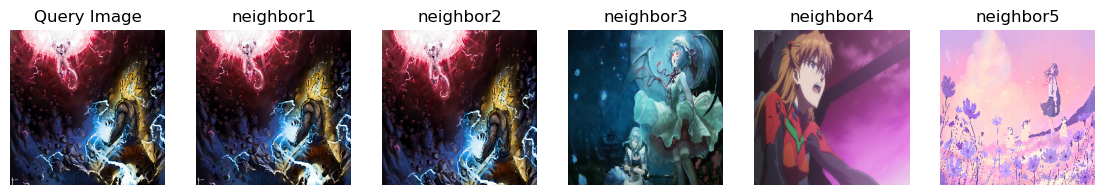

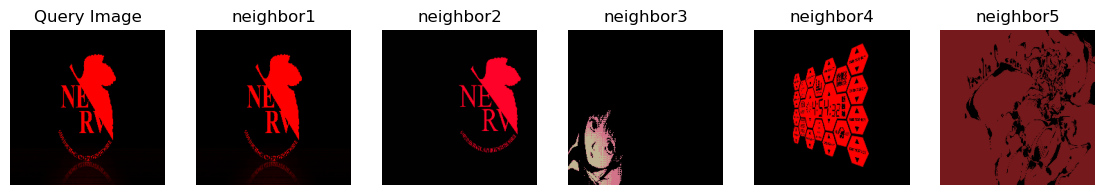

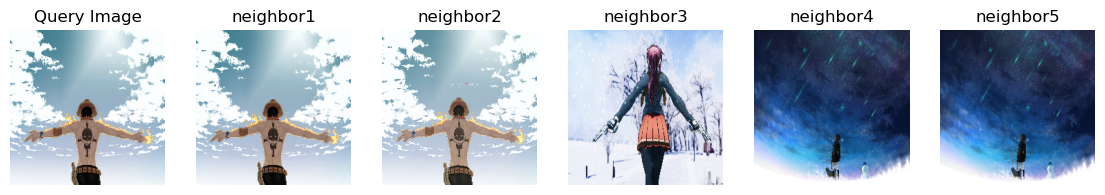

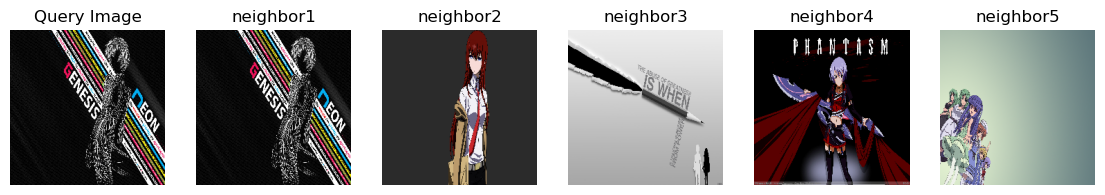

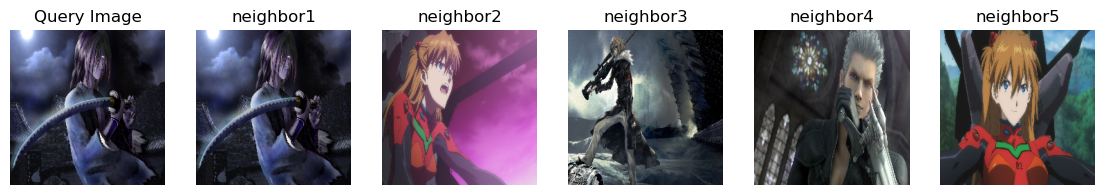

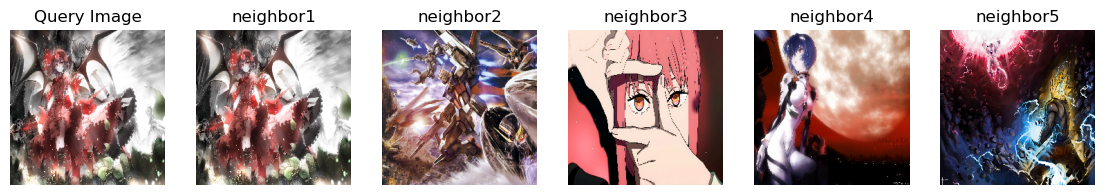

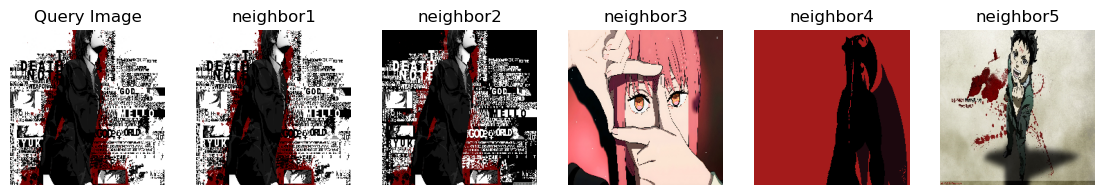

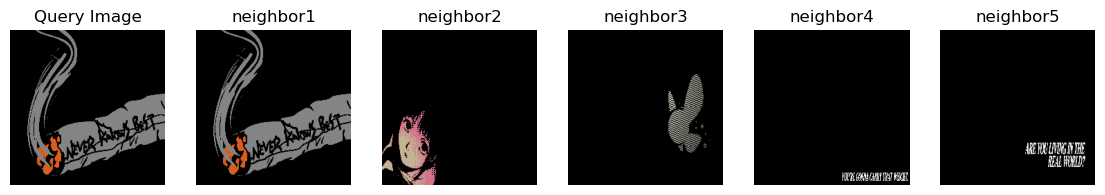

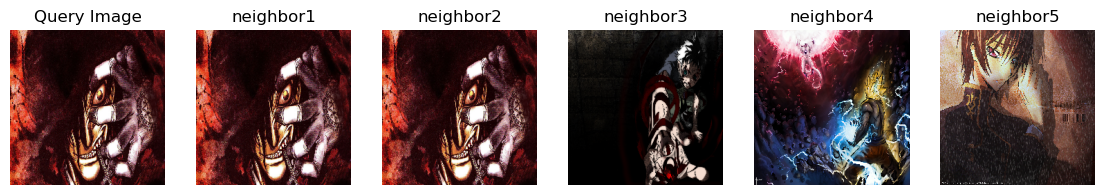

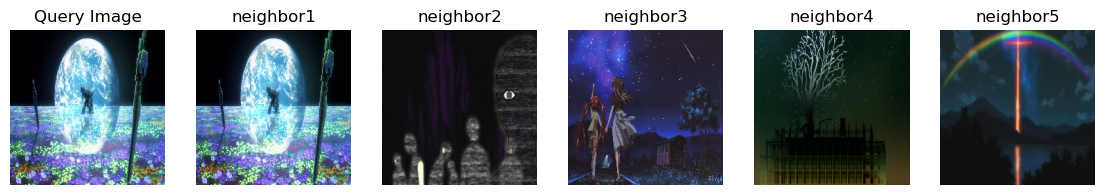

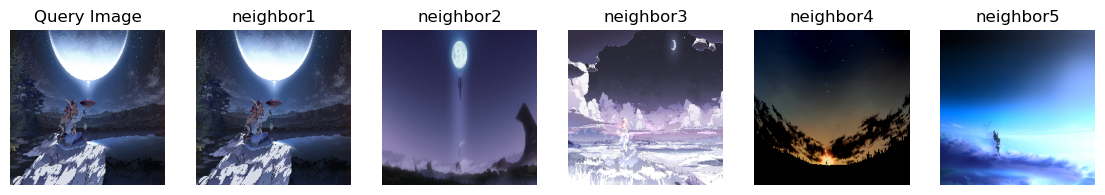

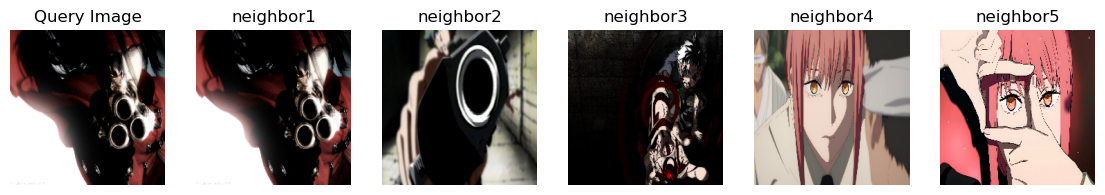

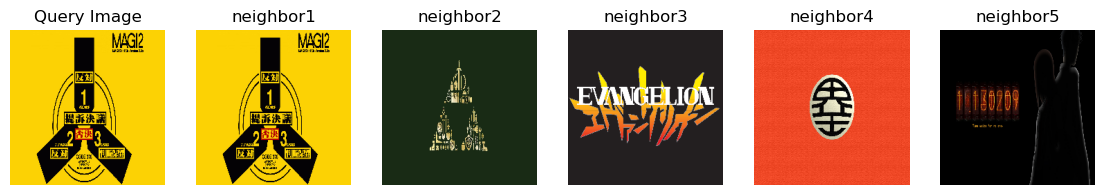

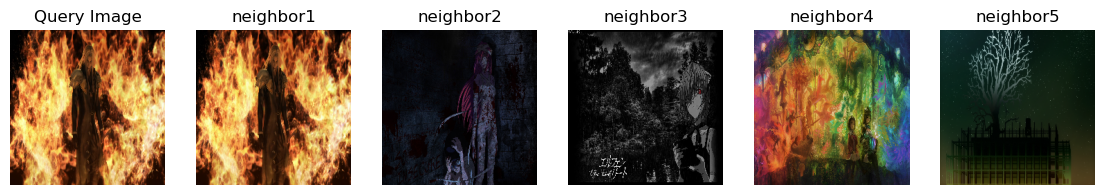

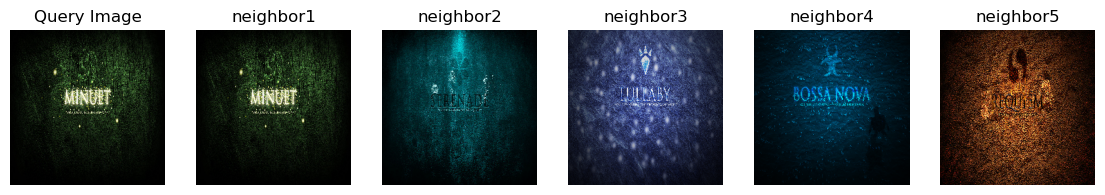

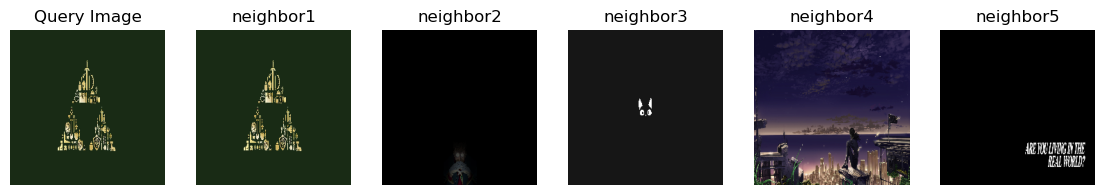

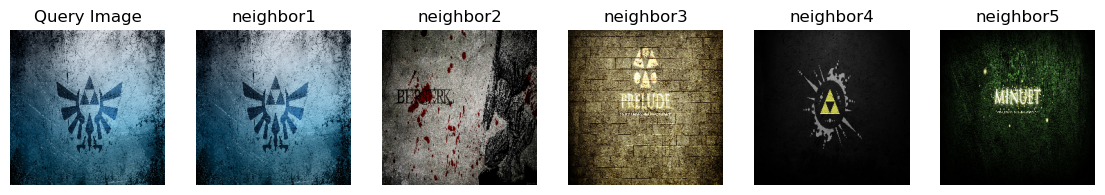

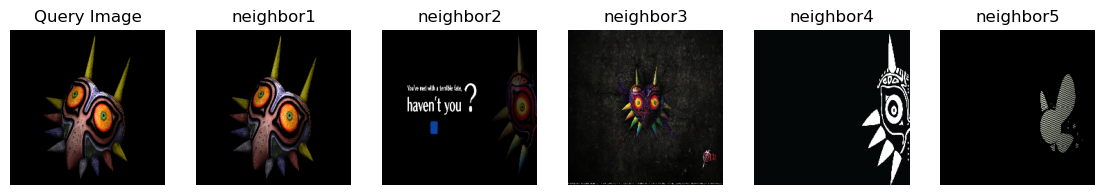

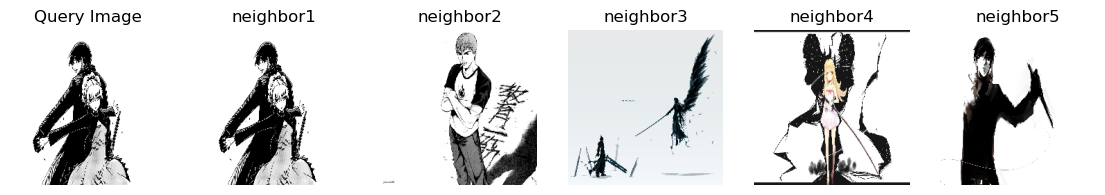

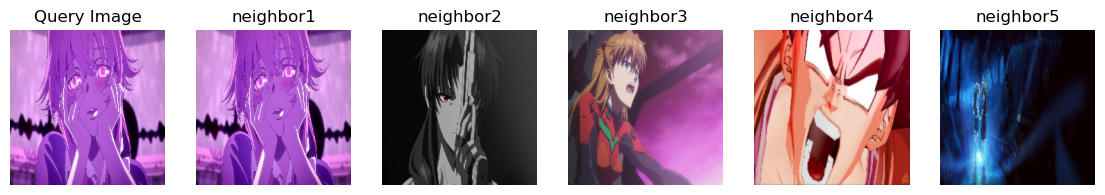

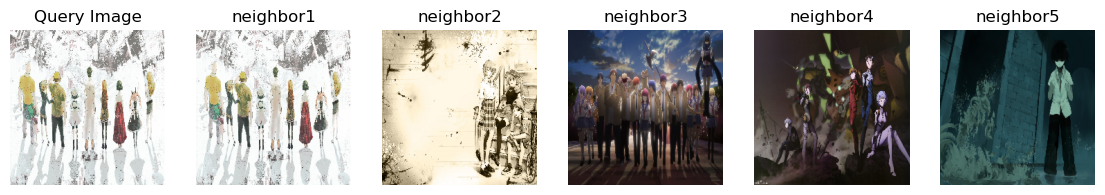

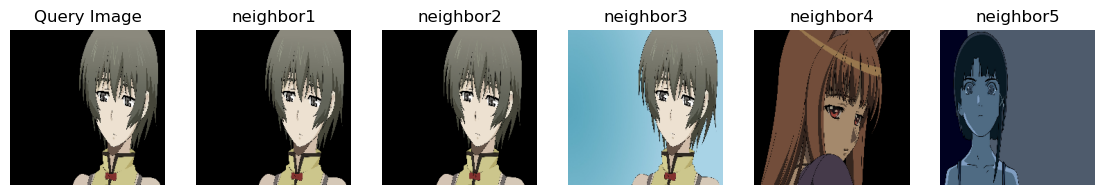

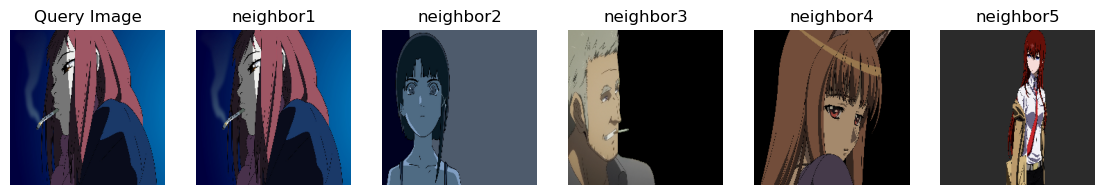

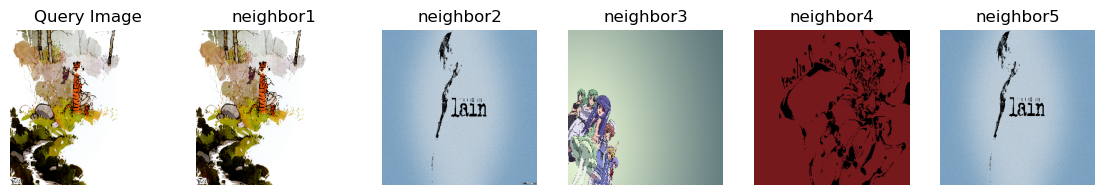

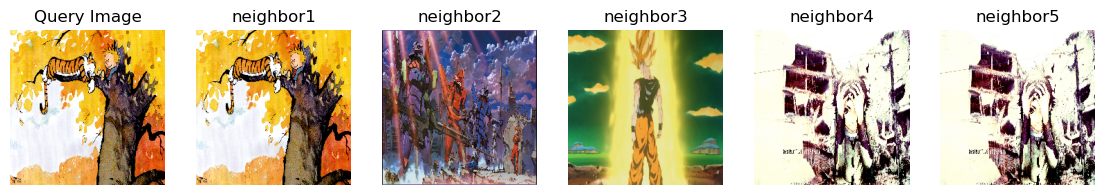

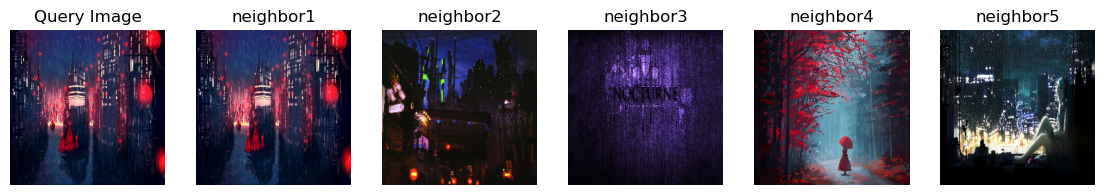

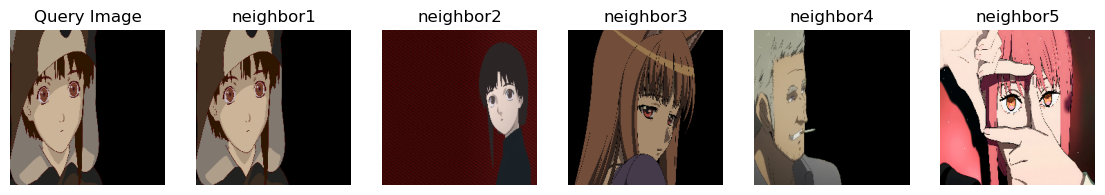

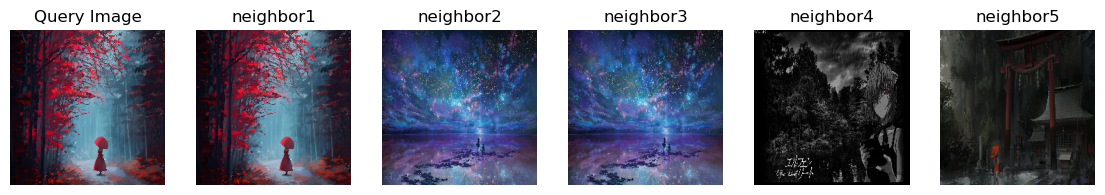

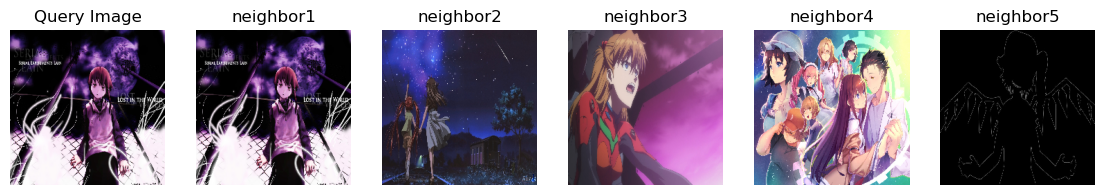

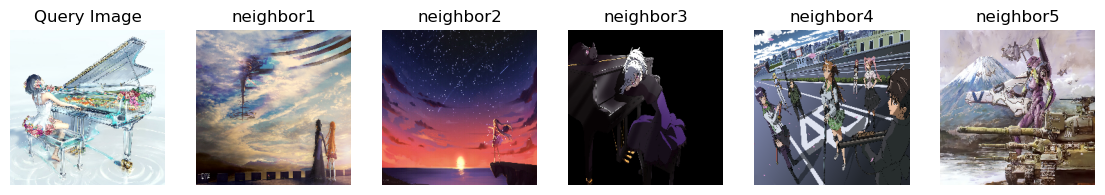

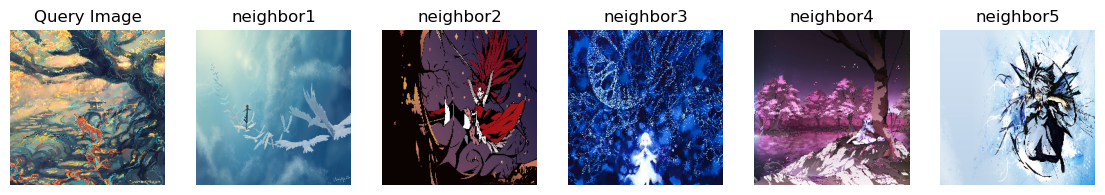

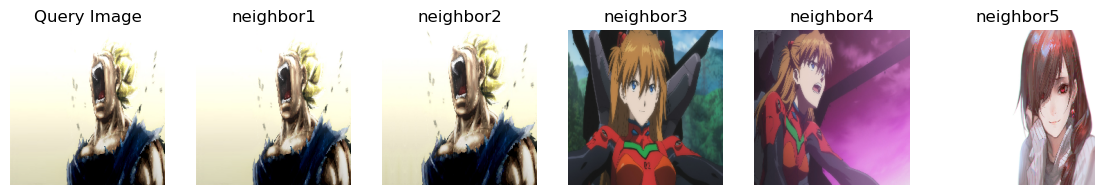

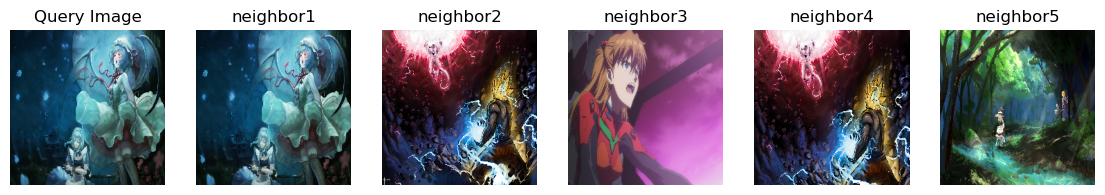

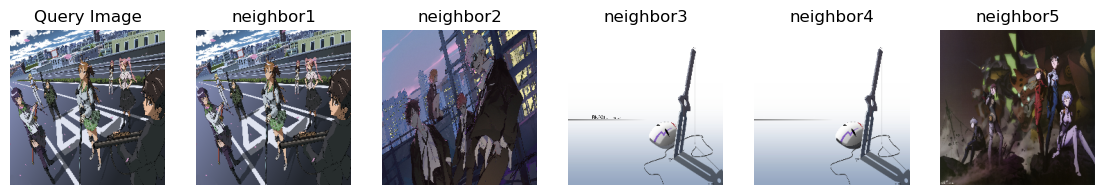

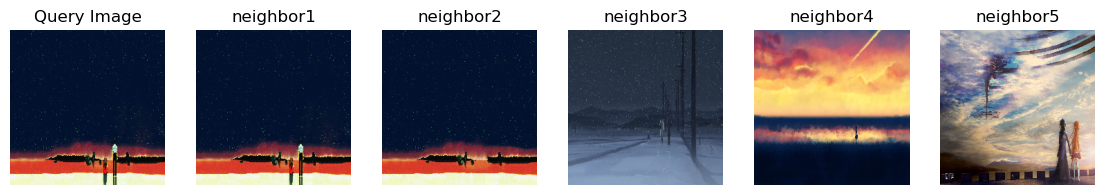

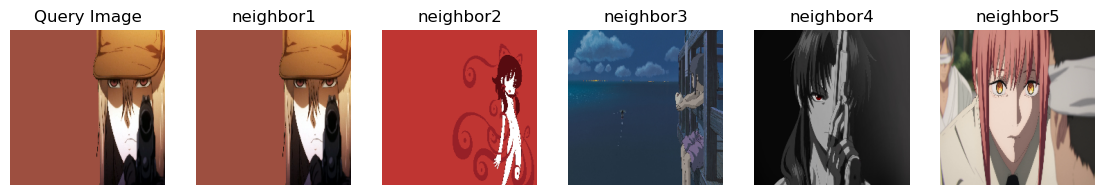

-----------------------------------------------------------


In [20]:
knn_images = []
# Iterate through all test images (last 'test_size' images of dataset)
for i in range(test_E.shape[0]):
    img = test_images[i]
    e = test_E[i].reshape(1, -1)
    result = get_knn_for_query(img, e, knnbr, train_images)
    # show the results
    show_images(result, '1')

print('-----------------------------------------------------------')   

**Input your own image**

To input your own image, replace the image in the `test_image/` directory with your own input image. Running this cell will give you the 5 nearest neighbors. Change the K parameter to get as many neighbors as you see fit.

Loading 1 images


100%|██████████| 1/1 [00:00<00:00, 25.48it/s]

images loaded as <class 'PIL.Image.Image'> type


1/1 [==============================] - 0s 271ms/step
Gettings embedding of img no. 0, with shape (4096,), and 1 layers


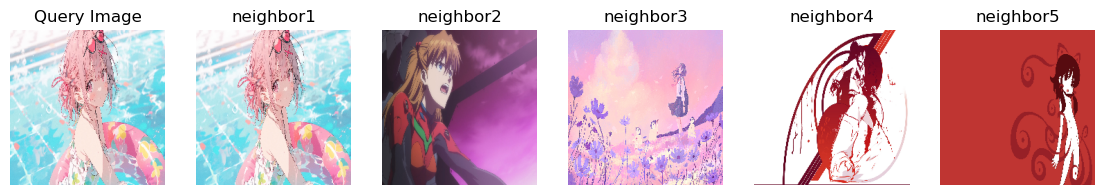

In [23]:
img_path = 'test_image/'
test_image = []
view_test_image = []

# Load query image
img = load_images(img_path)

# Select the layer from which to extract feature maps (conv1_1 is layer 0)
f_levels = [23]
# Get the embeddings of the query image
e = get_embeddings(f_levels, img)

result = get_knn_for_query(img[0], e, knnbr, train_images)

# Show the results
show_images(result, '1')

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


- Improve layer selection criteria (last conv layer of block instead of first one) [30 mins]
- filter out duplicates [1 hrs]
- Modularize for app instead of notebook [2 hrs]

- Add UI
- host ui